# Project 2 - Ames Housing Data and Kaggle Challenge

In [1]:
# note to self: see ***to do*** items in notes for future upgrades

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# EDA and Data Cleaning

## 1. Import the data sets

In [3]:
# import training dataset to dataframe
train = pd.read_csv('./datasets/train.csv')

In [4]:
# import test dataset to dataframe
test = pd.read_csv('./datasets/test.csv')

In [5]:
print(train.shape)
print(test.shape)
# train has 1 more column than test because it has the target variable 'SalePrice'

(2051, 81)
(879, 80)


## 1. Columns and data types

In [6]:
# Check that test columns are the same as train columns

list(test.columns) == list(train.drop('SalePrice', axis=1).columns)

True

In [7]:
# check columns and data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

In [8]:
# 'Id', 'PID', 'SalePrice' are not features
# 'Id' and 'PID' are property ID numbers that should not affect sale price
# 'SalePrice' is the target, which will be removed from X before the train test split

drop_cols = ['Id', 'PID']
ames_train = train.drop(drop_cols, axis=1)
kaggle_test = test.drop(drop_cols, axis=1)

In [9]:
# per data documentation here http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
# the following columns have numeric values but are years:
# Year Built (Discrete): Original construction date
# Year Remod/Add (Discrete): Remodel date (same as construction date if no remodeling or additions)
# Garage Yr Blt (Discrete): Year garage was built

# ***to do*** convert years to a more useful numeric value, age in years at time of sale
# for example:
# ames_train['Built_age'] = ames_train['Yr Sold'] - ames_train['Year Built']

In [10]:
# create numerical & categorical features lists
# ref Riley's video for ._get_numeric_data() 
# https://www.youtube.com/watch?v=y6AQcj2vOOw&list=PLYGvOQTnahYKInRCq3_Q4viVR56dHX2x5

# per data documentation here http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
# the following columns have numeric values but data is categorical:
# MS SubClass (Nominal): Identifies the type of dwelling involved in the sale.
# Mo Sold (Discrete): Month Sold (MM)
# Yr Sold (Discrete): Year Sold (YYYY)
# (Yr Sold unique values: 2006, 2007, 2008, 2009, 2010)

features_num = list(ames_train._get_numeric_data().drop(['MS SubClass', 'Mo Sold', 'Yr Sold', 'SalePrice'], axis=1))
features_cat = [x for x in ames_train.columns if (x not in features_num) and (x != 'SalePrice')]

In [11]:
# convert numeric categorical columns into strings (columns to be dummied later)

ames_train['MS SubClass'] = ames_train['MS SubClass'].astype(str)
ames_train['Mo Sold'] = ames_train['Mo Sold'].astype(str)
ames_train['Yr Sold'] = ames_train['Yr Sold'].astype(str)

kaggle_test['MS SubClass'] = kaggle_test['MS SubClass'].astype(str)
kaggle_test['Mo Sold'] = kaggle_test['Mo Sold'].astype(str)
kaggle_test['Yr Sold'] = kaggle_test['Yr Sold'].astype(str)

## 2. Missing values

In [12]:
# check percentage of null values by column

ames_train.isnull().mean().sort_values(ascending=False)

Pool QC            0.995612
Misc Feature       0.968308
Alley              0.931741
Fence              0.804973
Fireplace Qu       0.487567
Lot Frontage       0.160897
Garage Qual        0.055583
Garage Cond        0.055583
Garage Yr Blt      0.055583
Garage Finish      0.055583
Garage Type        0.055095
Bsmt Exposure      0.028279
BsmtFin Type 2     0.027304
Bsmt Qual          0.026816
BsmtFin Type 1     0.026816
Bsmt Cond          0.026816
Mas Vnr Type       0.010726
Mas Vnr Area       0.010726
Bsmt Half Bath     0.000975
Bsmt Full Bath     0.000975
Bsmt Unf SF        0.000488
Total Bsmt SF      0.000488
BsmtFin SF 1       0.000488
BsmtFin SF 2       0.000488
Garage Cars        0.000488
Garage Area        0.000488
Exterior 2nd       0.000000
Exterior 1st       0.000000
Roof Matl          0.000000
Roof Style         0.000000
                     ...   
Condition 2        0.000000
Heating QC         0.000000
Foundation         0.000000
Heating            0.000000
Yr Sold            0

In [13]:
# Drop columns with high percentage of null values

drop_cols = ['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu']
ames_train = ames_train.drop(drop_cols, axis=1)
kaggle_test = kaggle_test.drop(drop_cols, axis=1)
for x in drop_cols:
    if x in features_num:
        features_num.remove(x)
    elif x in features_cat:
        features_cat.remove(x)

In [14]:
# Set all numeric null values to 0 and string null values to 'null' 
# (this is not the best method of imputing missing values)
# first version of project tried dropping all rows/columns with missing values, which is worse
# ***to do*** for future versions: try filling missing values with median/most common value for that column
# see code from https://stackoverflow.com/questions/32617811/imputation-of-missing-values-for-categories-in-pandas

ames_train[features_num] = ames_train[features_num].fillna(0)
kaggle_test[features_num] = ames_train[features_num].fillna(0)
ames_train[features_cat] = ames_train[features_cat].fillna('null')
kaggle_test[features_cat] = ames_train[features_cat].fillna('null')

## 2. Feature selection and feature engineering

In [15]:
# Correlation
# find numeric variables with highest correlation (positive or negative) with SalePrice
# note: using all columns shows correlation with other columns that should not be used as variables
# PID	0.255052
# Id	0.051398

np.abs(train.corr()[['SalePrice']]).sort_values('SalePrice', ascending=False)

,SalePrice
SalePrice,1.000000
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650270
Garage Cars,0.648220
Total Bsmt SF,0.628925
1st Flr SF,0.618486
Year Built,0.571849
Year Remod/Add,0.550370
Full Bath,0.537969


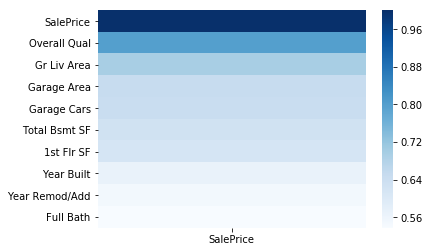

In [16]:
# create heatmap of top correlations
top_corr = np.abs(ames_train.corr()[['SalePrice']]).sort_values('SalePrice', ascending=False)
sns.heatmap(top_corr.head(10), cmap='Blues')

In [17]:
# Interaction Terms

# create interaction term for total SF
# TotalSF = 'Total Bsmt SF' + '1st Flr SF' + '2nd Flr SF'
# note: data also includes Gr Liv Area (Continuous): Above grade (ground) living area square feet

def add_totalSF(df):
    df['TotalSF'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']

add_totalSF(ames_train)
add_totalSF(kaggle_test)
features_num.append('TotalSF')

# drop from features to avoid collinearity with TotalSF
features_num = [x for x in features_num if x not in ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF']]

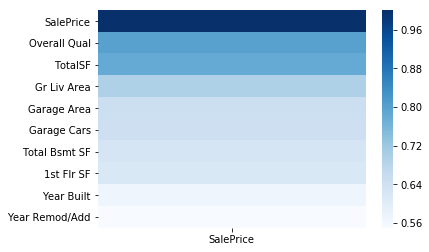

In [18]:
# check if TotalSF has a high correlation w/SalePrice
top_corr = np.abs(ames_train.corr()[['SalePrice']]).sort_values('SalePrice', ascending=False)
sns.heatmap(top_corr.head(10), cmap='Blues')

In [19]:
# ***to do*** reassign values with low counts to 'OTHER' in each features_cat column?

In [20]:
# ***to do*** look at neighborhoods specifically? create map?

In [21]:
# Dummies
# (convert each categorical column into a one-hot encoded matrix)

In [22]:
ames_train.shape

(2051, 75)

In [23]:
# get_dummies

ames_train = pd.get_dummies(ames_train, columns=features_cat, drop_first=True) 

In [24]:
ames_train.shape

(2051, 271)

In [25]:
# create list of features including new dummies

features_model = [x for x in ames_train.columns if x != 'SalePrice']

In [26]:
# get dummies for kaggle_test & fix missing columns

In [27]:
kaggle_test = pd.get_dummies(kaggle_test, columns=features_cat, drop_first=True) 

In [28]:
kaggle_test.shape

(879, 260)

In [29]:
ames_train[features_model].shape

(2051, 270)

In [30]:
# from https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
# Find missing columns in test
missing_cols = set(ames_train.columns) - set(kaggle_test.columns)
# Add a missing column in test with default value equal to 0
for c in missing_cols:
    kaggle_test[c] = 0
# Ensure the order of columns in test is the same as in train
kaggle_test = kaggle_test[features_model]

In [31]:
kaggle_test.shape

(879, 270)

In [32]:
# ***to do*** try taking the log of the target variable before fitting the model, 
# as was pointed out in other presentations that the sale price distribution is skewed. 
# (The final predictions would then have to be exponentiated to get the correct values.)    

# Model

## 3. Train test split

In [33]:
# train test split

X = ames_train[features_model]
y = ames_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42,
                                                    test_size=0.05)

In [34]:
# cross-validation of train test split

lr = linear_model.LinearRegression()
print(cross_val_score(lr, X_train, y_train, cv=3))
print(cross_val_score(lr, X_train, y_train, cv=3).mean())

[0.91036681 0.81846246 0.7099057 ]
0.8129116547653941


## 4. Scale data 

In [35]:
# Standardize X_train and X_test using Standard Scaler

# Instantiate Standard Scaler
ss = StandardScaler()

# Fit Standard Scaler to X_train and transform X_train
X_train_sc = ss.fit_transform(X_train)

# Transform X_test using Standard Scaler
X_test_sc = ss.transform(X_test)

# Standardize kaggle_test using Standard Scaler
ss = StandardScaler()
kaggle_test_sc = ss.fit_transform(kaggle_test)

In [36]:
# ***to do*** try scaling data before modeling with linear_model.LinearRegression() also

## 5. Lasso

In [37]:
# create linear model using Lasso
linear = linear_model.LassoCV()
model = linear.fit(X_train_sc, y_train)

In [38]:
# check score of X_train vs X_test for overfit
print(model.score(X_train_sc, y_train))
print(model.score(X_test_sc, y_test))

0.9097482576807232
0.9008261948983242


In [39]:
# find features with highest coefficients from Lasso

lasso_features = pd.DataFrame(X_train.columns, columns=['feature'])
lasso_features['coef'] = model.coef_
lasso_features['abs_coef'] = np.abs(model.coef_)
lasso_features.sort_values(by='abs_coef', ascending=False).head(10)

,feature,coef,abs_coef
2,Overall Qual,14286.053537,14286.053537
14,Gr Liv Area,12677.932176,12677.932176
218,Kitchen Qual_TA,-10459.193130,10459.193130
88,Neighborhood_NridgHt,9624.674083,9624.674083
217,Kitchen Qual_Gd,-9482.967444,9482.967444
33,TotalSF,9463.121208,9463.121208
167,Exter Qual_TA,-6691.364151,6691.364151
4,Year Built,6353.967942,6353.967942
94,Neighborhood_StoneBr,6019.881927,6019.881927
128,Roof Matl_CompShg,5678.871166,5678.871166


## 6. Predict target values

In [40]:
# prediction function

y_pred = model.predict(kaggle_test_sc)
y_pred.mean()

181329.39219712527

In [41]:
y_pred.shape

(879,)

In [42]:
# create submission dataframe with predictions

In [43]:
submission = pd.DataFrame(y_pred, columns=['SalePrice'])
submission['Id'] = test['Id']
submission = submission[['Id', 'SalePrice']]

In [44]:
submission.head()

,Id,SalePrice
0,2658,180005.038398
1,2718,236348.871969
2,2414,140045.923431
3,1989,154069.882608
4,625,151552.429728


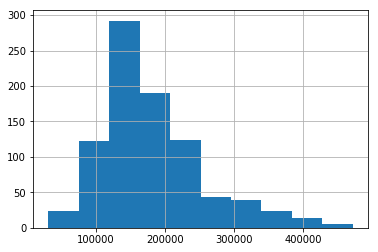

In [45]:
submission['SalePrice'].hist()

In [46]:
# write predictions to csv
submission.to_csv('submission_04', index=False)

In [47]:
# submission_04 upload to Kaggle: 
# RMSE (Public score based on only 30% of the test data): 29372.39816
# Final score (based on remaining 70% of the test data): ?